In [2]:
import pandas as pd
import numpy as np

In [316]:
import psycopg2
conn=psycopg2.connect(database="ernie",user="wenxi",host="localhost",password="temp_ERNIE_1234")
conn.set_client_encoding('UTF8')
conn.autocommit=True
curs=conn.cursor()

In [317]:
curs.execute("SET SEARCH_PATH TO wenxi;")

### Import Individual Kinetics Data

In [5]:
individual = pd.read_sql('SELECT * FROM sleep_beauty_1380_individual_kinetics_update', conn)
individual = individual.sort_values(['cited_1','pub_year']).reset_index().drop(columns='index')

In [6]:
individual

,cited_1,pub_year,count,cited_1_pub_year
0,10019696,1979,2,1979
1,10019696,1980,16,1979
2,10019696,1981,11,1979
3,10019696,1982,18,1979
4,10019696,1983,15,1979
...,...,...,...,...
50522,9847976,2015,28,1980
50523,9847976,2016,46,1980
50524,9847976,2017,32,1980
50525,9847976,2018,35,1980


### Fill missing years between first cited year and last cited year (2019) 

In [7]:
individual['pub_year'] = individual['pub_year'].astype(int)

In [8]:
k = list([individual['cited_1'], individual['pub_year']])

In [9]:
k_new = [[],[]]

for i in range(len(k[0])-1):    
    if k[1][i+1] - k[1][i] > 1:
        k_new[0].append(k[0][i])
        k_new[1].append(k[1][i])
        for j in range(1, (k[1][i+1] - k[1][i])):
            k_new[0].append(k[0][i])
            k_new[1].append(k[1][i]+j)

    else:
        k_new[0].append(k[0][i])
        k_new[1].append(k[1][i])
        
    if i == (len(k[0])-1):
        k_new[0].append(k[0][i+1])
        k_new[1].append(k[1][i+1])


In [10]:
k2 = pd.DataFrame({'cited_paper':k_new[0], 'year':k_new[1]})

In [11]:
k2 = k2.merge(individual, how='left', left_on=['cited_paper','year'], right_on=['cited_1','pub_year'])

In [12]:
k2 = k2[['cited_paper','year','count','cited_1_pub_year']]

In [13]:
import math

for i in range(len(k2)):
    if math.isnan(k2['count'][i]):
        k2['count'][i] = 0
    if math.isnan(k2['cited_1_pub_year'][i]):
        k2['cited_1_pub_year'][i] = k2['cited_1_pub_year'][i-1]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [14]:
b = list(set(k_new[0]))
len(b)

1398

### Fill missing years between publication year and first cited year

In [15]:
y0 = pd.DataFrame(k2.groupby(['cited_paper'])['year'].min()).reset_index()

In [16]:
k3 = k2.merge(y0, how='left', on='cited_paper')
k3.columns = ['cited_paper','year','count','cited_paper_pub_year','min_year']
k3

,cited_paper,year,count,cited_paper_pub_year,min_year
0,10019696,1979,2.0,1979.0,1979
1,10019696,1980,16.0,1979.0,1979
2,10019696,1981,11.0,1979.0,1979
3,10019696,1982,18.0,1979.0,1979
4,10019696,1983,15.0,1979.0,1979
...,...,...,...,...,...
52595,9847976,2014,35.0,1980.0,1980
52596,9847976,2015,28.0,1980.0,1980
52597,9847976,2016,46.0,1980.0,1980
52598,9847976,2017,32.0,1980.0,1980


In [17]:
x1 = pd.DataFrame(columns=k3.columns, index=[0])


for i in range(len(b)):
    g = k3[(k3['cited_paper'] == b[i])]
    g = g.reset_index().drop(columns='index')
    
    if g['min_year'][0] != g['cited_paper_pub_year'][0]:
        
        a0 = int(g['min_year'][0] - g['cited_paper_pub_year'][0])
        x2 = pd.DataFrame(columns=k3.columns, index=[x for x in range(a0)])
        
        
        for j in range(0, int(g['min_year'][0] - g['cited_paper_pub_year'][0])):
            x2['cited_paper'][j] = g['cited_paper'][j]
            x2['year'][j] = g['min_year'][0]-j-1
            x2['count'][j] = 0
            x2['cited_paper_pub_year'][j] = g['cited_paper_pub_year'][j]
            x2['min_year'][j] = g['min_year'][j]
 
        x1 = pd.concat([x1,g], ignore_index = True)
        x1 = pd.concat([x1,x2], ignore_index = True)
    
    else:
        x1 = pd.concat([x1,g], ignore_index = True)

In [18]:
x1 = x1.dropna().sort_values(['cited_paper', 'year']).drop(columns='min_year')

In [19]:
x1.head()

,cited_paper,year,count,cited_paper_pub_year
44740,10019696,1979,2,1979
44741,10019696,1980,16,1979
44742,10019696,1981,11,1979
44743,10019696,1982,18,1979
44744,10019696,1983,15,1979


### Apply van Raan's method to define individual publications as sleep beauty

1. Sleep Duration s: at least 10 years after publication

2. Citation Rate during Sleeping cs: between 0 and 1 

3. Awakening Intensity cw: for the following 5 years after sleeping the intensity is larger than 5

In [21]:
x1

,cited_paper,year,count,cited_paper_pub_year
44740,10019696,1979,2,1979
44741,10019696,1980,16,1979
44742,10019696,1981,11,1979
44743,10019696,1982,18,1979
44744,10019696,1983,15,1979
...,...,...,...,...
24493,9847976,2014,35,1980
24494,9847976,2015,28,1980
24495,9847976,2016,46,1980
24496,9847976,2017,32,1980


In [37]:
x = pd.DataFrame(columns=x1.columns)

for i in range(len(b)):
    g = x1[(x1['cited_paper'] == b[i])]
    g = g.reset_index().drop(columns='index')
    
    j_max = 0
    for j in range(10, len(g)):
        if (g['count'][0:j].mean() <= 1) & (g['count'][0:j].mean() >= 0) & (g['count'][j+1:j+6].mean() >= 5):
            j_max = j
        
    if j_max != 0:
        x = pd.concat([x,g], ignore_index=True)

In [68]:
x['cited_paper'] = x['cited_paper'].astype(int)

In [69]:
len(x.cited_paper.unique())

123

In [70]:
x.cited_paper.unique()

array([   24098349,    16094253,    20060819,     1581047,    21681627,
          19608784,     2518210,     2420331, 34250256884,      771451,
       84978092325, 33645921615,    18004847, 84948588467,    15200912,
          15039994,     1316531,    15127532,    17024036,    17424014,
          16521728,    20828868,    18456173, 84971791384,      619409,
       84941155240,    19854870, 23544447930, 34848895767, 52449140068,
          22715928, 51249187945, 84972893020,    25531716,    15989446,
       34250285541,    20814501,    18175277,    17996501,    16810564,
       49549151853,      605667,    15387804,    20969228,     2460135,
          22823251, 84916547635,    19547652,    18104527,    18057468,
       58149417330,      691940,    21758020, 35448975107,    19178773,
       77956890234,    15980602,    15033920,    21162985, 84966221118,
          20166653,    17919858,      846533,    21892216,     1652148,
          23581045,     9094601, 36149045284,     1335714,      

### Apply Ke's method to define individual publications as sleep beauty

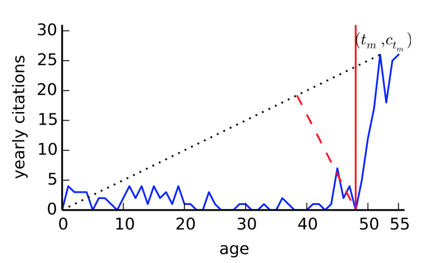

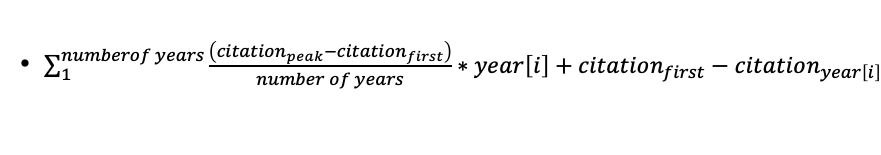

In [158]:
y = pd.DataFrame(x1.groupby(['cited_paper'])['count'].max().reset_index())

In [159]:
x2 = x1.merge(y, how='left', on=['cited_paper'])
x2.columns = ['cited_paper','year','count','cited_paper_pub_year','peak_count']

In [160]:
y1 = x2[['cited_paper','year']][x2['count'] == x2['peak_count']].drop_duplicates(subset=['cited_paper'], keep = 'first')

In [161]:
x3 = x2.merge(y1, how='right', on=['cited_paper'])
x3.columns = ['cited_paper','year','count', 'cited_paper_pub_year','peak_count','peak_year']

In [162]:
x3 = x3.reset_index().drop(columns='index')

In [163]:
y2 = x3[['cited_paper','count']][x3['year'] == x3['cited_paper_pub_year']]

In [164]:
x4 = x3.merge(y2, how='left', on=['cited_paper'])
x4.columns = ['cited_paper','year','count', 'cited_paper_pub_year','peak_count','peak_year', 'pub_year_count']

In [165]:
x4['max_1'] = 1
x4['max_1_ct'] = x4[['count', 'max_1']].max(axis=1)

In [166]:
x4['l_t'] = ((x4['peak_count'] - x4['pub_year_count'])/(x4['peak_year'] - x4['cited_paper_pub_year'])) * (x4['year'] - x4['cited_paper_pub_year']) + x4['pub_year_count']

In [167]:
x4['sb'] = (x4['l_t'] - x4['count'])/x4['max_1_ct']

In [168]:
x5 = x4[x4['peak_year'] >= x4['year']]

In [169]:
sb = pd.DataFrame(x5.groupby(['cited_paper'])['sb'].sum())
sb = sb.sort_values('sb', ascending=False).reset_index()

In [170]:
sb['cited_paper'] = sb['cited_paper'].astype(int)

In [171]:
sb['sb'].describe()

count    1398.000000
mean      162.239037
std       316.352916
min        -6.868166
25%        37.370422
50%        82.113643
75%       177.790976
max      7623.566516
Name: sb, dtype: float64

In [232]:
len(sb[sb['sb'] >= 0].cited_paper.unique())

1361

### Sleeping Beauty Identified by Ke and van Raan

In [303]:
s = []

for i in range(len(x.cited_paper.unique())):
    if x.cited_paper.unique()[i] in (sb[sb['sb'] > sb['sb'].quantile(0.9)].cited_paper.unique()):
        s.append(int(x.cited_paper.unique()[i]))

In [304]:
len(s)

42

In [305]:
s

[21681627,
 2420331,
 771451,
 15039994,
 1316531,
 15127532,
 17024036,
 84941155240,
 34848895767,
 22715928,
 84972893020,
 18175277,
 17996501,
 16810564,
 19547652,
 58149417330,
 35448975107,
 77956890234,
 15980602,
 84966221118,
 17919858,
 36149045284,
 16925857,
 15844590,
 2942611661,
 34250421484,
 20752342,
 6244299654,
 16626908,
 11691848,
 14811477,
 19148101,
 33750445111,
 17973511,
 36849099978,
 33646099212,
 18041874,
 33749522333,
 16918810,
 36149048221,
 15209415,
 930143]

### Check Pairs that Contains SB Individual Publications

In [318]:
p = pd.read_sql('SELECT * FROM sleep_beauty_pairs_table_complete', conn)
p = p.sort_values(['cited_1','cited_2','co_cited_year']).reset_index().drop(columns='index')

In [319]:
l = list([p['cited_1'], p['cited_2'], p['co_cited_year']])

In [320]:
l_new = [[],[],[]]

for i in range(len(l[0])-1):
    if (l[0][i] == l[0][i+1]) & (l[1][i] == l[1][i+1]):
        if l[2][i+1] - l[2][i] > 1:
            l_new[0].append(l[0][i])
            l_new[1].append(l[1][i])
            l_new[2].append(l[2][i])
            for j in range(1, (l[2][i+1] - l[2][i])):
                l_new[0].append(l[0][i])
                l_new[1].append(l[1][i])
                l_new[2].append(l[2][i]+j)

        else:
            l_new[0].append(l[0][i])
            l_new[1].append(l[1][i])
            l_new[2].append(l[2][i])
        
    else:
        l_new[0].append(l[0][i])
        l_new[1].append(l[1][i])
        l_new[2].append(l[2][i])
        
    if i == (len(l[0])-1):
        l_new[0].append(l[0][i+1])
        l_new[1].append(l[1][i+1])
        l_new[2].append(l[2][i+1])


In [321]:
d = pd.DataFrame({'cited_1':l_new[0], 'cited_2':l_new[1], 'co_cited_year':l_new[2]})

In [322]:
d1 = d.merge(p, how='left', on=['cited_1', 'cited_2', 'co_cited_year'])

In [323]:
for i in range(len(d1)):
    if math.isnan(d1['co_citations'][i]):
        d1['co_citations'][i] = 0
    if math.isnan(d1['cited_1_pub_year'][i]):
        d1['cited_1_pub_year'][i] = d1['cited_1_pub_year'][i-1]
    if math.isnan(d1['cited_2_pub_year'][i]):
        d1['cited_2_pub_year'][i] = d1['cited_2_pub_year'][i-1]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [324]:
d1['first_possible_year'] = ''

for i in range(len(d1)):
    if d1['cited_1_pub_year'][i] >= d1['cited_2_pub_year'][i]:
        d1['first_possible_year'][i] = d1['cited_1_pub_year'][i]
    elif d1['cited_1_pub_year'][i] < d1['cited_2_pub_year'][i]:
        d1['first_possible_year'][i] = d1['cited_2_pub_year'][i]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [325]:
d1['cited_1'] = d1['cited_1'].astype(int)
d1['cited_2'] = d1['cited_2'].astype(int)

In [326]:
d1.head()

,cited_1,cited_2,co_cited_year,co_citations,cited_1_pub_year,cited_2_pub_year,first_possible_year
0,10019696,35348875044,1979,1.0,1979.0,1972.0,1979
1,10019696,35348875044,1980,4.0,1979.0,1972.0,1979
2,10019696,35348875044,1981,4.0,1979.0,1972.0,1979
3,10019696,35348875044,1982,5.0,1979.0,1972.0,1979
4,10019696,35348875044,1983,1.0,1979.0,1972.0,1979


In [327]:
data = pd.DataFrame(d1.groupby(['cited_1','cited_2']).size()).reset_index().drop(columns=0)

In [328]:
x1 = pd.DataFrame(columns=d1.columns, index=[0])


for i in range(len(data)):
    g = d1[(d1['cited_1'] == data['cited_1'][i]) & (d1['cited_2'] == data['cited_2'][i])]
    g = g.reset_index().drop(columns='index')
    
    if g['first_possible_year'][0] != g['co_cited_year'][0]:
        
        a1 = int(g['first_possible_year'][0] - g['co_cited_year'][0])
        x2 = pd.DataFrame(columns=d1.columns, index=[x for x in range(a1)])
        
        
        for j in range(0, int(g['first_possible_year'][0] - g['co_cited_year'][0])):
            x2['cited_1'][j] = g['cited_1'][j]
            x2['cited_2'][j] = g['cited_2'][j]
            x2['co_cited_year'][j] = g['first_possible_year'][0]-j-1
            x2['co_citations'][j] = 0
            x2['cited_1_pub_year'][j] = g['cited_1_pub_year'][j]
            x2['cited_2_pub_year'][j] = g['cited_2_pub_year'][j]
            x2['first_possible_year'][j] = g['first_possible_year'][j]
 
        x1 = pd.concat([x1,g], ignore_index = True)
        x1 = pd.concat([x1,x2], ignore_index = True)
    
    else:
        x1 = pd.concat([x1,g], ignore_index = True)

In [329]:
x1 = x1.dropna()
x1 = x1.reset_index().drop(columns='index')

In [330]:
x1.head()

,cited_1,cited_2,co_cited_year,co_citations,cited_1_pub_year,cited_2_pub_year,first_possible_year
0,6297,84976779342,1994,2,1978,1980,1980
1,6297,84976779342,1995,2,1978,1980,1980
2,6297,84976779342,1996,1,1978,1980,1980
3,6297,84976779342,1997,2,1978,1980,1980
4,6297,84976779342,1998,1,1978,1980,1980


In [331]:
data['number_of_sb'] = ''

for i in range(len(data)):
    if data['cited_1'][i] in s and data['cited_2'][i] not in s:
        data['number_of_sb'][i] = 1
    elif data['cited_1'][i] not in s and data['cited_2'][i] in s:
        data['number_of_sb'][i] = 1 
    elif data['cited_1'][i] in s and data['cited_2'][i] in s:
        data['number_of_sb'][i] = 2
    elif data['cited_1'][i] not in s and data['cited_2'][i] not in s:
        data['number_of_sb'][i] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7

In [332]:
data.groupby(['number_of_sb']).count()

,cited_1,cited_2
number_of_sb,,
0,1308,1308
1,65,65
2,7,7
